Import packages and mount to google drive

In [ ]:
from collections import Counter
import numpy as np
import torch
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

KeyboardInterrupt: ignored

In [6]:
!ls ../

bin			    datalab  lib     media		       proc	   sbin  tools
boot			    dev      lib32   mnt		       python-apt  srv	 usr
content			    etc      lib64   NGC-DL-CONTAINER-LICENSE  root	   sys	 var
cuda-keyring_1.0-1_all.deb  home     libx32  opt		       run	   tmp


Part 2:  Getting Data

In [ ]:
data = pd.read_csv('Colab Notebooks/data.tsv', sep='\t')

In [ ]:
data.columns

Index(['text', 'label'], dtype='object')

In [ ]:
train_set,test_validate_set = train_test_split(data, train_size = 0.64, stratify=data['label'])
test_set,validate_set = train_test_split(test_validate_set, train_size = 0.16/(1-0.64), stratify=test_validate_set['label'])
overfit,drop = train_test_split(data, train_size=50/len(data), stratify =data['label'])

In [ ]:
def test_equal_proportions(subset, label):
  counts = subset.groupby(['label']).count()
  if len(set(list(train_set.groupby(['label']).count()['text']))) != 1:
    raise Exception('the prediction classes are not equally proportioned')



In [ ]:
data = pd.read_csv('Colab Notebooks/data.tsv', sep='\t')

def create_subsets(data, label):
  train_size = 0.64
  test_size = 0.20
  validation_size = 0.16
  overfit_size = 50
  train_set,test_validate_set = train_test_split(data, train_size = train_size, stratify=data[label])
  test_set,validate_set = train_test_split(test_validate_set, train_size = validation_size/(validation_size+test_size), stratify=test_validate_set[label])
  overfit,drop = train_test_split(data, train_size=overfit_size/len(data), stratify =data[label])


  for i,subset in enumerate((train_set, test_set,validate_set, overfit)):
    #test the proportions are equal
    counts = subset.groupby(['label']).count()
    if len(set(list(train_set.groupby(['label']).count()['text']))) != 1:
      raise Exception('the prediction classes are not equally proportioned')
    if i==0:
      checking_repeats = subset.reset_index()
    elif i<3:
      checking_repeats = checking_repeats.merge(subset.reset_index(),
                                                on=['index', 'text'], how='outer', indicator=True)
      if len(checking_repeats[checking_repeats['_merge']=='both'])!=0:
        raise Exception('Two subsets contain the same data!')
      else:
        checking_repeats = checking_repeats.drop(['_merge'],axis=1)
  return train_set, test_set,validate_set, overfit

train_set, test_size,validate_set, overfit=create_subsets(data, 'label')

train_set.to_csv('train.tsv', sep='\t')
validate_set.to_csv('validate.tsv', sep='\t')
test_set.to_csv('test.tsv', sep='\t')
overfit.to_csv('overfit.tsv', sep='\t')



In [ ]:
train_set, test_size,validate_set, overfit=create_subsets(data, 'label')

In [ ]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
glove = torchtext.vocab.GloVe(name="6B", dim=args.emb_dim)

In [ ]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd

In [ ]:
class SubjectiveObjectiveModel(torch.nn.Module):
    def __init__(self, vocab, embedding_size):
        super().__init__()
        # initialize word vectors to random numbers

        #TO DO
        #initial_embedding = torch.rand(embedding_size, vocab_size)
        self.embeddings = torch.nn.Embedding.from_pretrained(vocab.vectors)

        self.mean = torch.mean

        self.layer1 = torch.nn.Linear(embedding_size,1)
        self.sigmoid = torch.nn.Sigmoid()
        #TO DO

    def forward(self, x):
        """
        x: torch.tensor of shape (bsz), bsz is the batch size
        """
        embeddings = self.embeddings(x)
        avg_per_sentence = self.mean(embeddings, dim=0)
        logits = self.layer1(avg_per_sentence)

        sigmoid_results = self.sigmoid(logits)
        return logits, sigmoid_results

In [ ]:


# TextDataset is Described in Section 3.3 of Assignment 2
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "a2/data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

def accurate_count(sigmoid_results, y):
  rounded_results = torch.round(sigmoid_results).squeeze()
  accurate = torch.eq(rounded_results.int(),y.int())
  return accurate.sum()


def model_test_or_validate(dataloader, network,loss_fn):
  losses = 0
  lens = 0
  accuracy = 0
  for batch, (X,y) in enumerate(dataloader):
    logits, sigmoid_results = network(X)
    loss = loss_fn(logits, y.float().unsqueeze(1))
    losses += loss*y.size(0)
    accuracy +=accurate_count(sigmoid_results,y)
    lens += y.size(0)
  acc = accuracy/lens
  return losses/lens, acc

def train_model(args, vocab, train_dataloader, test_dataloader, validation_dataloader):
    # Set up a model with Skip-gram (predict context with word)
    # textlist: a list of the strings

    # Create the training data

    size = len(train_dataloader)

    # instantiate the network & set up the optimizer
    # TO DO

    embedding_size =100
    network = SubjectiveObjectiveModel(vocab, embedding_size)
    network.train()
    loss_fn = torch.nn.BCEWithLogitsLoss()
    learning_rate=0.1
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

    train_loss = []
    val_loss  = []
    train_accuracy = []
    val_accuracy = []
    val_epoch = []
    # training loop    val_loss = []
    for epoch in range(args.epochs):
      epoch_loss = 0
      epoch_count = 0
      epoch_accuracy = 0
      for batch, (X,y) in enumerate(train_dataloader):

          optimizer.zero_grad()
          #Compute prediction and loss
          logits, sigmoid_results = network(X) # this returns the matrix logits, and the softmax of the batch
          loss = loss_fn(logits,
                        y.float().unsqueeze(1))  # loss function of only the output logits options and the actual values

          # Backpropagation
          loss.backward()
          optimizer.step()

          epoch_loss += loss * y.size(0)
          epoch_count += y.size(0)
          epoch_accuracy += accurate_count(sigmoid_results, y)

          if batch % 500 == 0:
              loss, current = loss.item(), (batch + 1) * len(X)
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

      #train results
      train_loss.append(float(epoch_loss/epoch_count))
      train_accuracy.append(float(epoch_accuracy/epoch_count))

      #val results
      if epoch % 2 == 0:
        epoch_val_loss,epoch_val_accuracy = model_test_or_validate(validation_dataloader, network,loss_fn)
        val_loss.append(float(epoch_val_loss))
        val_accuracy.append(float(epoch_val_accuracy))
        val_epoch.append(epoch)

    # TO DO
    test_loss, test_accuracy = model_test_or_validate(test_dataloader, network, loss_fn)
    print("test accuracy:", test_accuracy)
    print("test loss:", test_loss)

    # plot lines
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(range(args.epochs), train_loss, label = "train loss")
    ax1.plot(val_epoch, val_loss, label = "validation loss")
    ax1.legend()

    ax2.plot(range(args.epochs), train_accuracy, label = "train accuracy")
    ax2.plot(val_epoch, val_accuracy, label = "validation accuracy")
    ax2.legend()
    plt.show()

    return network

def main(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    ### 3.3 Processing of the data ###
    # 3.3.1
    # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

    # 3.3.2

    train_dataset = TextDataset(glove, "train")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")

    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with
    network = train_model(args, glove, train_dataloader, test_dataloader, validation_dataloader)
    return network

In [ ]:
def main_overfit(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    ### 3.3 Processing of the data ###
    # 3.3.1
    # The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
    glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

    # 3.3.2

    train_dataset = TextDataset(glove, "overfit")
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")

    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with
    network = train_model(args, glove, train_dataloader, test_dataloader, validation_dataloader)
    print(network)


In [ ]:
class args_get():
  def __init__(self):
    self.batch_size = 2**4
    self.epochs = 50
    self.learning_rate = 0.001


Using device: cpu
tensor([[ 0.0229, -0.0238,  0.0274, -0.0051,  0.0427,  0.0238, -0.0115, -0.0808,
          0.0228, -0.0885,  0.0131,  0.0066, -0.0220,  0.0818,  0.0067,  0.0415,
          0.0423, -0.0590, -0.0384,  0.0962, -0.0979, -0.0068, -0.0079,  0.0709,
         -0.0095,  0.0263, -0.0048, -0.0560, -0.0567, -0.0486, -0.0908, -0.0649,
          0.0235,  0.0658,  0.0049, -0.0458,  0.0439, -0.0384, -0.0222, -0.0548,
         -0.0314, -0.0927,  0.0427,  0.0389,  0.0199,  0.0491,  0.0424,  0.0044,
          0.0106,  0.0076,  0.0534,  0.0672,  0.0718,  0.0580, -0.0244, -0.0045,
         -0.0203,  0.0582,  0.0111,  0.0926,  0.0507, -0.0855,  0.0293,  0.0961,
          0.0888, -0.0016,  0.0332, -0.0938, -0.0319,  0.0488, -0.0911,  0.0871,
         -0.0658,  0.0316, -0.0038,  0.0176,  0.0097, -0.0935, -0.0215, -0.0632,
          0.0850, -0.0123, -0.0996,  0.0242,  0.0434, -0.0448, -0.0094,  0.0432,
         -0.0622, -0.0529, -0.0096, -0.0702,  0.0615,  0.0082,  0.0598,  0.0535,
         -

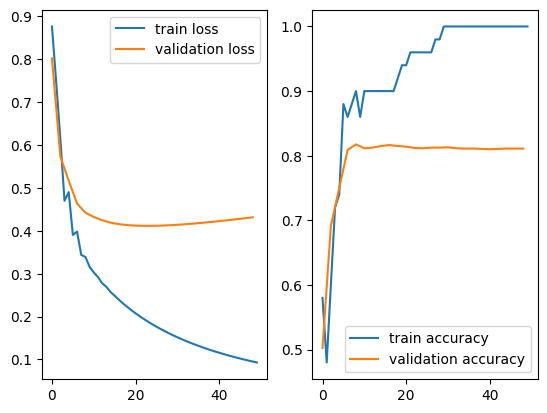

SubjectiveObjectiveModel(
  (embeddings): Embedding(400000, 100)
  (layer1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
args.batch_size = 2**3
main_overfit(args)

Using device: cpu
tensor([[ 0.0229, -0.0238,  0.0274, -0.0051,  0.0427,  0.0238, -0.0115, -0.0808,
          0.0228, -0.0885,  0.0131,  0.0066, -0.0220,  0.0818,  0.0067,  0.0415,
          0.0423, -0.0590, -0.0384,  0.0962, -0.0979, -0.0068, -0.0079,  0.0709,
         -0.0095,  0.0263, -0.0048, -0.0560, -0.0567, -0.0486, -0.0908, -0.0649,
          0.0235,  0.0658,  0.0049, -0.0458,  0.0439, -0.0384, -0.0222, -0.0548,
         -0.0314, -0.0927,  0.0427,  0.0389,  0.0199,  0.0491,  0.0424,  0.0044,
          0.0106,  0.0076,  0.0534,  0.0672,  0.0718,  0.0580, -0.0244, -0.0045,
         -0.0203,  0.0582,  0.0111,  0.0926,  0.0507, -0.0855,  0.0293,  0.0961,
          0.0888, -0.0016,  0.0332, -0.0938, -0.0319,  0.0488, -0.0911,  0.0871,
         -0.0658,  0.0316, -0.0038,  0.0176,  0.0097, -0.0935, -0.0215, -0.0632,
          0.0850, -0.0123, -0.0996,  0.0242,  0.0434, -0.0448, -0.0094,  0.0432,
         -0.0622, -0.0529, -0.0096, -0.0702,  0.0615,  0.0082,  0.0598,  0.0535,
         -

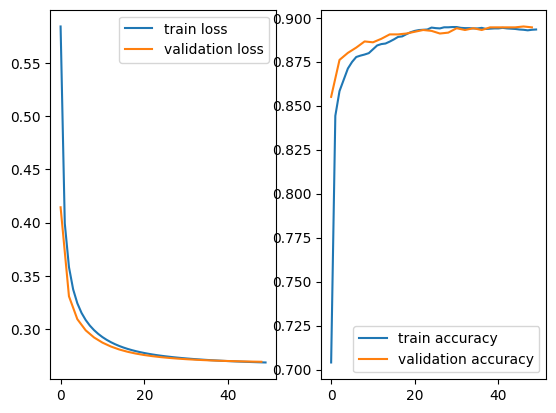

In [ ]:
args.batch_size = 2**6
network = main(args)

In [ ]:
network

SubjectiveObjectiveModel(
  (embeddings): Embedding(400000, 100)
  (layer1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# 4.5 What information is being ignored?

# the length of the sentence, punctuation, the true meaning of words which have been spelled incorrectly.

In [ ]:
glove = torchtext.vocab.GloVe(name="6B",dim=100)

In [ ]:
def print_closest_cosine_words(vec, n=5):
    dists = np.array([float(torch.cosine_similarity(x.unsqueeze(0),vec)) for x in glove.vectors])
    lst = sorted(enumerate(dists), key=lambda x: x[1])  # sort by abs min
    for idx, difference in lst[len(lst)-n-1:len(lst)-1]: # take the top n
        print(glove.itos[idx], "\t%5.2f" % difference)

print_closest_cosine_words(network.layer1.weight.data, n=20)

nuanced 	 0.43
hokum 	 0.43
heartening 	 0.43
pleasing 	 0.43
campy 	 0.44
ponderous 	 0.44
tepid 	 0.44
emptier 	 0.44
overacting 	 0.44
uninspired 	 0.44
underwhelming 	 0.44
perfunctory 	 0.44
interestingly 	 0.44
befuddling 	 0.45
praiseworthy 	 0.45
watchable 	 0.46
verbiage 	 0.46
laudatory 	 0.46
insipid 	 0.46
flattering 	 0.47


In [ ]:
# using the cosine distance, most of the words which are most similar to the single layer weights in the model make sense
# the words are all always used subjectively
# these words include nuance, heartnening, pleasing, campy, ponderous, tepid, overacting, uninspired, underwelmping, interestingly, praiseworthy and so on.
# the model has a vector which is encapsulated the idea of "subjective" and returns a higher number if the dot product of the input vector is similar to this comparison vecotr (the wieght)


In [ ]:
def print_closest_words(vec, n=5):
    dists = torch.norm(glove.vectors - vec, dim=1)     # compute distances to all words
    print(dists)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1]) # sort by distance
    for idx, difference in lst[1:n+1]:                         # take the top n
        print(glove.itos[idx], "\t%5.2f" % difference)

print_closest_words(network.layer1.weight.data, n=20)

tensor([46.5081, 46.6691, 46.3386,  ..., 45.8019, 46.2622, 45.8851])
gutty 	43.98
flattering 	44.05
funnily 	44.06
frontal 	44.12
watchable 	44.15
emptier 	44.16
narrowest 	44.18
visceral 	44.19
chardonnays 	44.19
v-8 	44.20
tannic 	44.22
17-inch 	44.22
tepid 	44.22
200-seat 	44.25
fellini 	44.26
legroom 	44.27
nuanced 	44.27
jaundiced 	44.28
cursory 	44.28
funnier 	44.28


In [ ]:
torch.save(network.state_dict(),'a2/model baseline.pt')

In [ ]:
# 4.6
#Some of the words make sense but not all of them.  included in the top 20 words are the words:
# flattering, funnility, watchable, nuanced, cursory, funnier and visceral.  These words are words that are always subjective.

In [ ]:
args.batch_size = 2**2
main(args)

In [ ]:
args.batch_size = 2**3
main(args)

Using device: cpu
tensor([[ 0.0229, -0.0238,  0.0274, -0.0051,  0.0427,  0.0238, -0.0115, -0.0808,
          0.0228, -0.0885,  0.0131,  0.0066, -0.0220,  0.0818,  0.0067,  0.0415,
          0.0423, -0.0590, -0.0384,  0.0962, -0.0979, -0.0068, -0.0079,  0.0709,
         -0.0095,  0.0263, -0.0048, -0.0560, -0.0567, -0.0486, -0.0908, -0.0649,
          0.0235,  0.0658,  0.0049, -0.0458,  0.0439, -0.0384, -0.0222, -0.0548,
         -0.0314, -0.0927,  0.0427,  0.0389,  0.0199,  0.0491,  0.0424,  0.0044,
          0.0106,  0.0076,  0.0534,  0.0672,  0.0718,  0.0580, -0.0244, -0.0045,
         -0.0203,  0.0582,  0.0111,  0.0926,  0.0507, -0.0855,  0.0293,  0.0961,
          0.0888, -0.0016,  0.0332, -0.0938, -0.0319,  0.0488, -0.0911,  0.0871,
         -0.0658,  0.0316, -0.0038,  0.0176,  0.0097, -0.0935, -0.0215, -0.0632,
          0.0850, -0.0123, -0.0996,  0.0242,  0.0434, -0.0448, -0.0094,  0.0432,
         -0.0622, -0.0529, -0.0096, -0.0702,  0.0615,  0.0082,  0.0598,  0.0535,
         -

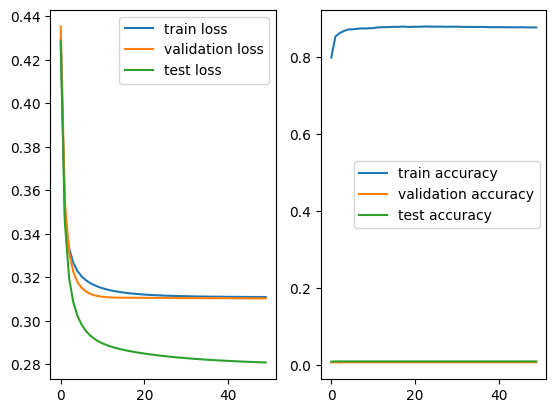

SubjectiveObjectiveModel(
  (embeddings): Embedding(400000, 100)
  (layer1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
args.batch_size=2**4
main(args)

Using device: cpu
tensor([[ 0.0229, -0.0238,  0.0274, -0.0051,  0.0427,  0.0238, -0.0115, -0.0808,
          0.0228, -0.0885,  0.0131,  0.0066, -0.0220,  0.0818,  0.0067,  0.0415,
          0.0423, -0.0590, -0.0384,  0.0962, -0.0979, -0.0068, -0.0079,  0.0709,
         -0.0095,  0.0263, -0.0048, -0.0560, -0.0567, -0.0486, -0.0908, -0.0649,
          0.0235,  0.0658,  0.0049, -0.0458,  0.0439, -0.0384, -0.0222, -0.0548,
         -0.0314, -0.0927,  0.0427,  0.0389,  0.0199,  0.0491,  0.0424,  0.0044,
          0.0106,  0.0076,  0.0534,  0.0672,  0.0718,  0.0580, -0.0244, -0.0045,
         -0.0203,  0.0582,  0.0111,  0.0926,  0.0507, -0.0855,  0.0293,  0.0961,
          0.0888, -0.0016,  0.0332, -0.0938, -0.0319,  0.0488, -0.0911,  0.0871,
         -0.0658,  0.0316, -0.0038,  0.0176,  0.0097, -0.0935, -0.0215, -0.0632,
          0.0850, -0.0123, -0.0996,  0.0242,  0.0434, -0.0448, -0.0094,  0.0432,
         -0.0622, -0.0529, -0.0096, -0.0702,  0.0615,  0.0082,  0.0598,  0.0535,
         -

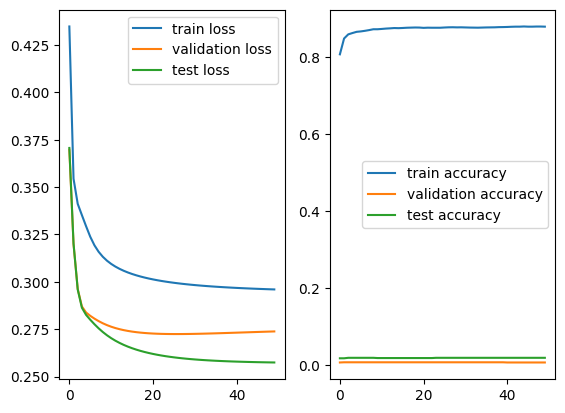

SubjectiveObjectiveModel(
  (embeddings): Embedding(400000, 100)
  (layer1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
args.batch_size = 2**5
main(args)

Using device: cpu
tensor([[ 0.0229, -0.0238,  0.0274, -0.0051,  0.0427,  0.0238, -0.0115, -0.0808,
          0.0228, -0.0885,  0.0131,  0.0066, -0.0220,  0.0818,  0.0067,  0.0415,
          0.0423, -0.0590, -0.0384,  0.0962, -0.0979, -0.0068, -0.0079,  0.0709,
         -0.0095,  0.0263, -0.0048, -0.0560, -0.0567, -0.0486, -0.0908, -0.0649,
          0.0235,  0.0658,  0.0049, -0.0458,  0.0439, -0.0384, -0.0222, -0.0548,
         -0.0314, -0.0927,  0.0427,  0.0389,  0.0199,  0.0491,  0.0424,  0.0044,
          0.0106,  0.0076,  0.0534,  0.0672,  0.0718,  0.0580, -0.0244, -0.0045,
         -0.0203,  0.0582,  0.0111,  0.0926,  0.0507, -0.0855,  0.0293,  0.0961,
          0.0888, -0.0016,  0.0332, -0.0938, -0.0319,  0.0488, -0.0911,  0.0871,
         -0.0658,  0.0316, -0.0038,  0.0176,  0.0097, -0.0935, -0.0215, -0.0632,
          0.0850, -0.0123, -0.0996,  0.0242,  0.0434, -0.0448, -0.0094,  0.0432,
         -0.0622, -0.0529, -0.0096, -0.0702,  0.0615,  0.0082,  0.0598,  0.0535,
         -

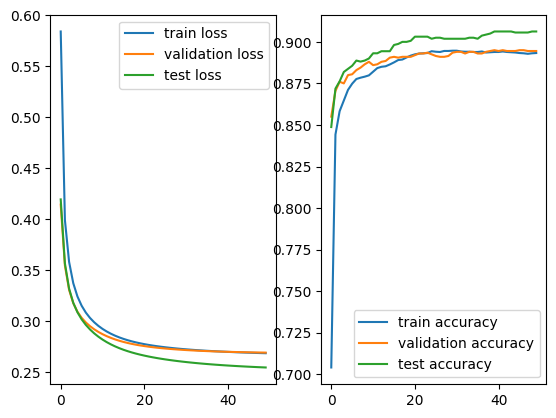

SubjectiveObjectiveModel(
  (embeddings): Embedding(400000, 100)
  (layer1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
args.batch_size = 2**6
main(args)

Using device: cpu
tensor([[ 0.0229, -0.0238,  0.0274, -0.0051,  0.0427,  0.0238, -0.0115, -0.0808,
          0.0228, -0.0885,  0.0131,  0.0066, -0.0220,  0.0818,  0.0067,  0.0415,
          0.0423, -0.0590, -0.0384,  0.0962, -0.0979, -0.0068, -0.0079,  0.0709,
         -0.0095,  0.0263, -0.0048, -0.0560, -0.0567, -0.0486, -0.0908, -0.0649,
          0.0235,  0.0658,  0.0049, -0.0458,  0.0439, -0.0384, -0.0222, -0.0548,
         -0.0314, -0.0927,  0.0427,  0.0389,  0.0199,  0.0491,  0.0424,  0.0044,
          0.0106,  0.0076,  0.0534,  0.0672,  0.0718,  0.0580, -0.0244, -0.0045,
         -0.0203,  0.0582,  0.0111,  0.0926,  0.0507, -0.0855,  0.0293,  0.0961,
          0.0888, -0.0016,  0.0332, -0.0938, -0.0319,  0.0488, -0.0911,  0.0871,
         -0.0658,  0.0316, -0.0038,  0.0176,  0.0097, -0.0935, -0.0215, -0.0632,
          0.0850, -0.0123, -0.0996,  0.0242,  0.0434, -0.0448, -0.0094,  0.0432,
         -0.0622, -0.0529, -0.0096, -0.0702,  0.0615,  0.0082,  0.0598,  0.0535,
         -

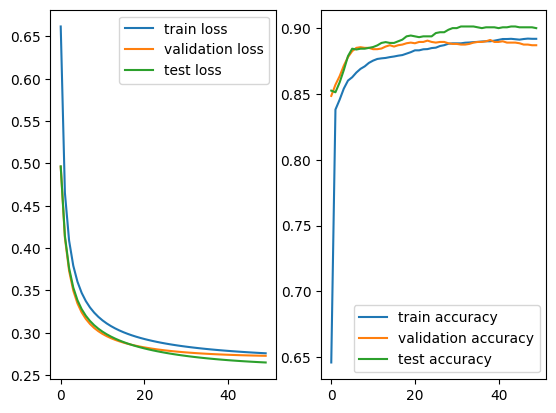

SubjectiveObjectiveModel(
  (embeddings): Embedding(400000, 100)
  (layer1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
args.batch_size = 2**7
main(args)

In [ ]:
# best seems to be 2 to the 6 or 7

Using device: cpu
tensor([[ 0.0229, -0.0238,  0.0274, -0.0051,  0.0427,  0.0238, -0.0115, -0.0808,
          0.0228, -0.0885,  0.0131,  0.0066, -0.0220,  0.0818,  0.0067,  0.0415,
          0.0423, -0.0590, -0.0384,  0.0962, -0.0979, -0.0068, -0.0079,  0.0709,
         -0.0095,  0.0263, -0.0048, -0.0560, -0.0567, -0.0486, -0.0908, -0.0649,
          0.0235,  0.0658,  0.0049, -0.0458,  0.0439, -0.0384, -0.0222, -0.0548,
         -0.0314, -0.0927,  0.0427,  0.0389,  0.0199,  0.0491,  0.0424,  0.0044,
          0.0106,  0.0076,  0.0534,  0.0672,  0.0718,  0.0580, -0.0244, -0.0045,
         -0.0203,  0.0582,  0.0111,  0.0926,  0.0507, -0.0855,  0.0293,  0.0961,
          0.0888, -0.0016,  0.0332, -0.0938, -0.0319,  0.0488, -0.0911,  0.0871,
         -0.0658,  0.0316, -0.0038,  0.0176,  0.0097, -0.0935, -0.0215, -0.0632,
          0.0850, -0.0123, -0.0996,  0.0242,  0.0434, -0.0448, -0.0094,  0.0432,
         -0.0622, -0.0529, -0.0096, -0.0702,  0.0615,  0.0082,  0.0598,  0.0535,
         -

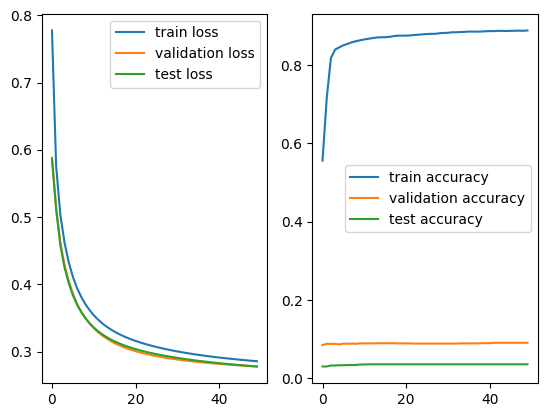

SubjectiveObjectiveModel(
  (embeddings): Embedding(400000, 100)
  (layer1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
args.batch_size = 2**8
main(args)